# Task 28: Voter Model, Role of Networks

The objective of this project is to investigate how the degree distribution of a network influences the dynamics of the voter model. In particular, the study compares the temporal evolution of the interface density $\rho(t)$ in scale-free networks, characterized by broad degree heterogeneity, with that in single-scale networks (Erdős–Rényi or random regular graphs) that lack such heterogeneity. By isolating the effect of the degree distribution, the aim is to understand whether and how network heterogeneity accelerates or suppresses consensus formation.

In [96]:
using Graphs
using Random
using Statistics
using Plots

# --- Helper: Interface density ---
function interface_density(g::SimpleGraph, state::Vector{Int})
    total = 0
    interface = 0
    for i in vertices(g)
        for j in neighbors(g, i)
            total += 1
            interface += state[i] != state[j] ? 1 : 0
        end
    end
    return interface / total
end


# --- Helper: Voter model dynamics ---
function voter_model(g::SimpleGraph, Tmax::Int, record_interval::Int)
    N = nv(g)
    state = rand([-1, 1], N)
    ρ = Float64[]

    for t in 1:Tmax
        # Asynchronous update: pick one node and copy one neighbor
        i = rand(1:N)
        nbrs = neighbors(g, i)
        if !isempty(nbrs)
            j = rand(nbrs)
            state[i] = state[j]
        end

        if t % record_interval == 0
            push!(ρ, interface_density(g, state))
        end
        if all(x -> x == state[1], state)
            # reached consensus, fill rest with zeros
            append!(ρ, zeros(length(record_times) - length(ρ)))
            break
        end
    end

    return ρ
end

# --- Helper: Run many simulations and average ---
function simulate_network(g::SimpleGraph, Tmax_sweeps::Int, record_interval_sweeps::Int, num_runs::Int)
    N = nv(g)
    Tsteps = Tmax_sweeps * N
    record_steps = record_interval_sweeps * N
    num_records = Int(Tsteps / record_steps)
    
    all_ρ = zeros(num_records)

    for run in 1:num_runs
        ρ = Float64[]
        state = rand([-1, 1], N)

        for t in 1:record_steps:Tsteps
            for _ in 1:record_steps
                i = rand(1:N)
                nbrs = neighbors(g, i)
                if !isempty(nbrs)
                    j = rand(nbrs)
                    state[i] = state[j]
                end
            end
            push!(ρ, interface_density(g, state))
        end

        all_ρ .+= ρ
    end

    return all_ρ ./ num_runs
end


# --- Network generators ---
function generate_ER(N, k_avg)
    p = k_avg / (N - 1)
    return erdos_renyi(N, p)
end

function generate_BA(N, k_avg)
    m = k_avg ÷ 2
    return Graphs.barabasi_albert(N, m)
end

function generate_EN(N, k_avg)
    # Like BA but no preferential attachment: connect to m random nodes
    m = k_avg ÷ 2
    g = SimpleGraph(N)
    for i in 2:N
        targets = rand(setdiff(1:i-1, neighbors(g, i)), m)
        for t in targets
            add_edge!(g, i, t)
        end
    end
    return g
end


generate_EN (generic function with 1 method)

In [ ]:
# --- Parameters ---
N = 10_000             # Number of nodes
k_avg = 8              # Target average degree
Tmax = 2000            # Max number of steps
num_runs = 1000        # Number of realizations
record_interval = 10   # Record every 10 steps

# --- Main ---
println("Simulating voter model...")

g_BA = generate_BA(N, k_avg)
g_RN = generate_ER(N, k_avg)
g_EN = generate_EN(N, k_avg)

ρ_BA = simulate_network(g_BA, Tmax, record_interval, num_runs)
ρ_RN = simulate_network(g_RN, Tmax, record_interval, num_runs)
ρ_EN = simulate_network(g_EN, Tmax, record_interval, num_runs)


## Comparison between Networks

In [ ]:
Ns = [1000, 2000, 5000, 10000]
k_avg = 8
Tmax = 10000
record_interval = 100
num_runs = 100  # use smaller runs for speed; increase for publication quality

# Store results
ρ_BA_all = Dict{Int, Vector{Float64}}()
ρ_RN_all = Dict{Int, Vector{Float64}}()
ρ_EN_all = Dict{Int, Vector{Float64}}()

for N in Ns
    println("Simulating for N = $N")

    g_BA = generate_BA(N, k_avg)
    g_RN = generate_ER(N, k_avg)
    g_EN = generate_EN(N, k_avg)

    ρ_BA_all[N] = simulate_network(g_BA, Tmax, record_interval, num_runs)
    ρ_RN_all[N] = simulate_network(g_RN, Tmax, record_interval, num_runs)
    ρ_EN_all[N] = simulate_network(g_EN, Tmax, record_interval, num_runs)
end


Simulating for N = 1000
Simulating for N = 2000
Simulating for N = 5000
Simulating for N = 10000


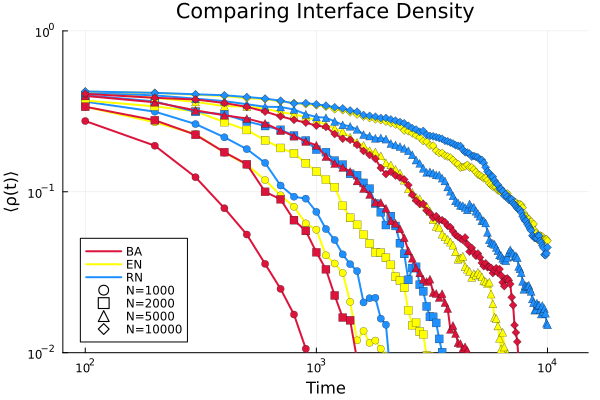

In [45]:
using Plots
ts = collect(record_interval:record_interval:Tmax)
markers = [:circle, :square, :utriangle, :diamond]

# Color for each network
colors = Dict(:BA => :crimson, :RN => :dodgerblue, :EN => :yellow)

#ρ_display = max.(ρ, ϵ)  # clip values from below


plt = plot(title="Comparing Interface Density", xlabel="Time", ylabel="⟨ρ(t)⟩", legend=false)

for (i, N) in enumerate(Ns)
    marker = markers[i]
    plot!(ts,  max.(ρ_EN_all[N], 1e-3), color=colors[:EN], marker=marker, lw=2, label ="", markersize=4, markerstrokewidth=0.3)
    plot!(ts,  max.(ρ_RN_all[N], 1e-3), color=colors[:RN], marker=marker, lw=2, label ="", markersize=4, markerstrokewidth=0.3)
    plot!(ts,  max.(ρ_BA_all[N], 1e-3), color=colors[:BA], marker=marker, lw=2, label ="", markersize=4, markerstrokewidth=0.3)

end

# Dummy entries for legend: network type (color)
plot!(ts, fill(NaN, length(ts)), label="BA", color=colors[:BA], lw=2)
plot!(ts, fill(NaN, length(ts)), label="EN", color=colors[:EN], lw=2)
plot!(ts, fill(NaN, length(ts)), label="RN", color=colors[:RN], lw=2)

# Dummy entries for legend: system size (marker)
for (i, N) in enumerate(Ns)
    plot!(ts, fill(NaN, length(ts)), label="N=$N", color=:white, marker=markers[i], lw=0)
end
#display(plot!())

plot!(legend=:bottomleft, xscale=:log10, yscale=:log10, ylims=(1e-2,1), xlims=(80,15000))  # Log-log scale for better visibility


In [46]:
savefig("comparing_interface_density.png")

"c:\\Users\\LENOVO PC\\Dropbox\\PC\\Desktop\\PoD\\Complex networks\\projects\\22_temporalepid\\comparing_interface_density.png"

## Interface Density in BA

In [ ]:
function interface_density(g::SimpleGraph, state::Vector{Int})
    E = ne(g)
    interface = 0
    for e in edges(g)
        i, j = src(e), dst(e)
        interface += (state[i] != state[j]) ? 1 : 0
    end
    return interface / E
end


# Average over many runs
function simulate_average(N, k_avg, Tmax_sweeps, record_interval, num_runs)
    m = k_avg ÷ 2
    num_records = Int(Tmax_sweeps / record_interval)
    avg_ρ = zeros(num_records)

    for run in 1:num_runs
        g = barabasi_albert(N, m)
        ρ = voter_model(g, Tmax_sweeps, record_interval)
        avg_ρ .+= ρ
    end

    return avg_ρ ./ num_runs
end


simulate_average (generic function with 1 method)

In [81]:
# Parameters
Ns = [1000, 2000, 5000, 10000, 20000, 50000]
k_avg = 3
Tmax = 10000      
record_interval = 100  
num_runs = 1000

# Simulate
results = Dict{Int, Vector{Float64}}()
for N in Ns
    println("Simulating BA voter model for N = $N")
    results[N] = simulate_average(N, k_avg, Tmax, record_interval, num_runs)
end

Simulating BA voter model for N = 1000
Simulating BA voter model for N = 2000
Simulating BA voter model for N = 5000
Simulating BA voter model for N = 10000
Simulating BA voter model for N = 20000
Simulating BA voter model for N = 50000


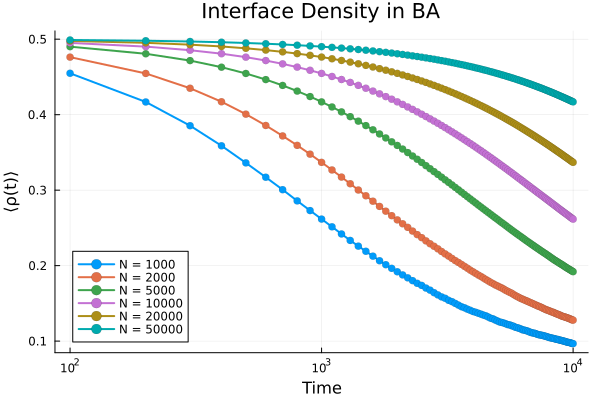

In [86]:
# Plot
ts = collect(record_interval:record_interval:Tmax)
plt = plot(title="Interface Density in BA", xlabel="Time", ylabel="⟨ρ(t)⟩")

for N in Ns
    plot!(ts, results[N], label="N = $N", lw=2, markershape=:circle, markersize=4, markerstrokewidth=0.1)
end
plot!(xscale=:log10, legend=:bottomleft)
#display(plt)

In [87]:
savefig("interface_density_ba.png")

"c:\\Users\\LENOVO PC\\Dropbox\\PC\\Desktop\\PoD\\Complex networks\\projects\\22_temporalepid\\interface_density_ba.png"

## Plateau in BA network

In [133]:
function compute_interface_density(G::Graph, opinions::Dict{Int, Int})
    different_edges = 0
    total_edges = ne(G)
    
    for edge in edges(G)
        if opinions[edge.src] != opinions[edge.dst]
            different_edges += 1
        end
    end
    
    return different_edges / total_edges
end
function voter_model_simulation(G::Graph, max_steps::Int=10000)
    N = nv(G)  # Number of nodes
    opinions = Dict(i => rand([-1, 1]) for i in 1:N)  # Randomly assign opinions
    interface_density_history = Float64[]

    for step in 1:max_steps
        for _ in 1:N  # Perform N updates per time step
            node = rand(1:N)  # Select a random node
            neighbors = Graphs.SimpleGraphs.neighbors(G, node)
            
            if !isempty(neighbors)
                opinions[node] = opinions[rand(neighbors)]  # Adopt opinion of a random neighbor
            end
        end

        # Compute interface density
        rho = compute_interface_density(G, opinions)
        push!(interface_density_history, rho)

        # Stop if consensus is reached

    end
    # Estimate plateau height (average after initial transient)
    valid_rho_values = filter(x -> x > 0.38, interface_density_history[10:end])
    plateau_height = isempty(valid_rho_values) ? 0 : mean(valid_rho_values)
    #plateau_height = mean(interface_density_history[end ÷ 2:end])
    return interface_density_history
end

voter_model_simulation (generic function with 2 methods)

In [ ]:
all_histories = [voter_model_simulation(g, Tmax_sweeps) for _ in 1:num_runs]

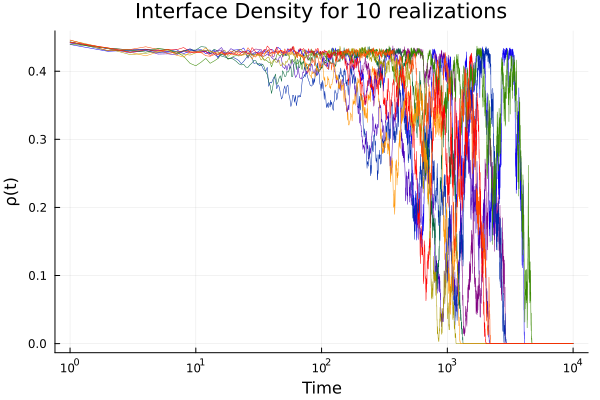

In [148]:
colors =palette(:rainbow, num_runs)
plot(title="Interface Density for 10 realizations", xlabel="Time", ylabel="ρ(t)", legend=false)
plot!(1:Tmax_sweeps, all_histories[1], label="", lw=0.5, color=colors[1])
plot!(1:Tmax_sweeps, all_histories[2], label="", lw=0.5, color=colors[2])
plot!(1:Tmax_sweeps, all_histories[3], label="", lw=0.5, color=colors[3])
plot!(1:Tmax_sweeps, all_histories[4], label="", lw=0.5, color=colors[4])
plot!(1:Tmax_sweeps, all_histories[5], label="", lw=0.5, color=colors[5])
plot!(1:Tmax_sweeps, all_histories[6], label="", lw=0.5, color=colors[6])
plot!(1:Tmax_sweeps, all_histories[7], label="", lw=0.5, color=colors[7])
plot!(1:Tmax_sweeps, all_histories[8], label="", lw=0.5, color=colors[8])
plot!(1:Tmax_sweeps, all_histories[9], label="", lw=0.5, color=colors[9])
plot!(1:Tmax_sweeps, all_histories[10], label="", lw=0.5, color=colors[10])
plot!(xscale=:log10)

In [149]:
savefig("plateau_ba.png")

"c:\\Users\\LENOVO PC\\Dropbox\\PC\\Desktop\\PoD\\Complex networks\\projects\\22_temporalepid\\plateau_ba.png"